In [1]:
import numpy as np


def generate_data(A, noise, count):
    """
        y = a0*x0 + a1*x1 + random(0, 1)*noise
    """
    X = np.random.normal(0, 1, (count, len(A)))
    y = np.dot(X, A) + np.random.normal(0, 1, (count)) * noise
    return y, X

y_train, X_train = generate_data([1, 2, 3], 10.1, 10000)
y_test, X_test = generate_data([1, 2, 3], 10.1, 1000)

print(y_train.shape, X_train.shape)
print(y_test.shape, X_test.shape)

(10000,) (10000, 3)
(1000,) (1000, 3)


In [2]:
def solve_pseudo_inverse(X, y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(solve_pseudo_inverse(X_train, y_train))

[1.09301242 1.9984909  2.82803518]


In [3]:
import sklearn.linear_model

def solve_sklearn(X, y):
    sgd = sklearn.linear_model.SGDRegressor(max_iter=1000, tol=1e-3, eta0=0.1)
    sgd.fit(X, y)
    return sgd

sgd = solve_sklearn(X_train, y_train)
print(sgd.intercept_, sgd.coef_)

[-0.19131612] [0.30874358 0.59059701 3.28172045]


In [4]:
def solve_sgd(X, y, iter, lr, eps):
    m, n = X.shape   # n - number of features, m - number of examples
    A = np.zeros(n)
    for _ in range(iter):
        t = 2 * (np.dot(X, A)-y)
        dA = np.mean(X.T * t, axis = 1)
        if np.max(np.abs(dA)) < eps:
            break
        A -= dA * lr
        #print(dA, A)
    return A

print(solve_sgd(X_train, y_train, 1000, 0.1, 0.00001))

[1.09301102 1.99848813 2.82803019]


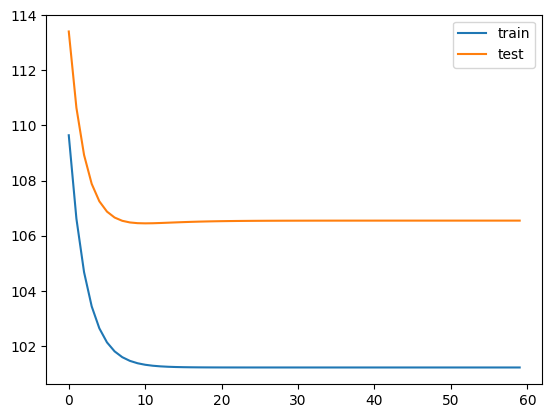

[1.09301102 1.99848813 2.82803019]


In [5]:
import matplotlib.pyplot as plt

def solve_sgd_plot(X_train, y_train, X_test, y_test, iter, lr, eps):
    n = X_train.shape[1]
    A = np.zeros(n)
    train_losses, test_losses = [], []
    for _ in range(iter):
        t = 2 * (np.dot(X_train, A)-y_train)
        dA = np.mean(X_train.T * t, axis = 1)
        if np.max(np.abs(dA)) < eps:
            break
        A -= dA * lr
        t = np.dot(X_train, A) - y_train
        t *= t
        train_losses.append(np.mean(t))
        t = np.dot(X_test, A) - y_test
        t *= t
        test_losses.append(np.mean(t))
    plt.plot(train_losses, label = "train")
    plt.plot(test_losses, label = "test")
    plt.legend()
    plt.show()
    return A

print(solve_sgd_plot(X_train, y_train, X_test, y_test, 1000, 0.1, 0.00001))

In [6]:
import catboost

def solve_catboost(X, y):
    model = catboost.CatBoostRegressor(iterations = 1000, learning_rate = 0.01, depth = 6)
    model.fit(X, y, verbose = False)
    return model

model = solve_catboost(X_train, y_train)

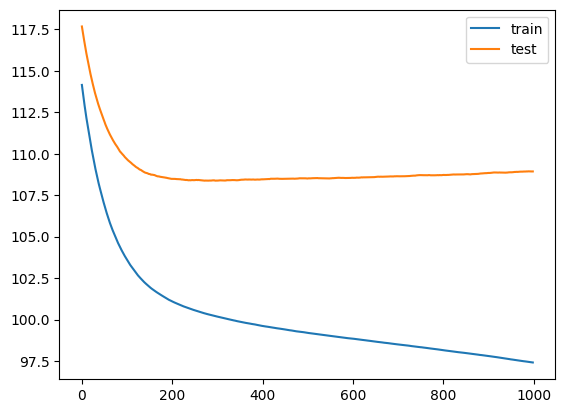

In [7]:
def calculate_losses(X, y, model):
    losses = []
    for i in range(1, model.tree_count_):
        t = model.predict(X, ntree_end = i)
        losses.append(np.mean((y - t) * (y - t)))
    return losses

plt.plot(calculate_losses(X_train, y_train, model), label = "train")
plt.plot(calculate_losses(X_test, y_test, model), label = "test")
plt.legend()
plt.show()